In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

### Week 3: Histopathologic Cancer Detection

#### Problem:
This project involves analyzing medical images and building a good CNN model to identify images showing symptoms of metastatic cancer. The data is sourced from https://www.kaggle.com/c/histopathologic-cancer-detection/overview, which itself is a slightly modified version of the PatchCamelyon dataset (supposedly with duplicates removed). The dataset is fairly large, with about 220,000 images in the training data (and another 57.5k for the test set). The training data comes with labels (for whether there is metastatic cancer).

#### EDA:
Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Starting with importing the training labels into a dataframe. Label data is pretty straightforward, 220,025 entries, with an id as well as the actual label (0 for no cancer, 1 for with cancer).

In [7]:
label_df = pd.read_csv('histopathologic-cancer-detection/train_labels.csv', dtype=str)

print(label_df.info())
print(label_df.columns)
label_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB
None
Index(['id', 'label'], dtype='object')


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Checking for null values or duplicate rows. The Kaggle mentions duplicates were removed, but want to make sure. Doesn't seem like there's any missing or duplicated values though, so not much to clean.

In [8]:
# Check for null
na_count = label_df.isna().sum()
print("Null count:", na_count)

# Check for dupes
dupes = label_df['id'].duplicated()
print("Duplicate rows: ", dupes.sum())

Null count: id       0
label    0
dtype: int64
Duplicate rows:  0


I want to check the distribution of images labeled 0 and 1 to see if it's imbalanced. Overall, there's more 0s than 1s, but it's not overly imbalanced.

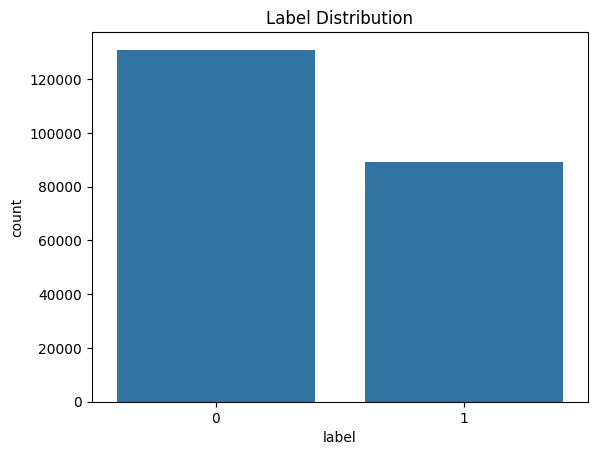

In [9]:
# Draw 0/1 label plot
sns.countplot(x='label', data=label_df)
plt.title('Label Distribution')
plt.show()

Showing some example images for reference. Also taking a look at image sizes, all images seem to be 96x96, which is good to know so I know what size input I'll need for the models.

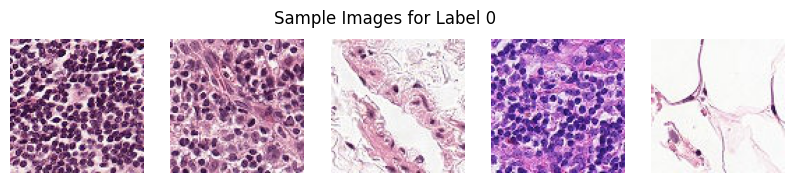

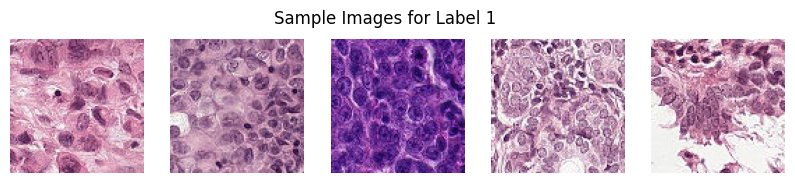

Image Sizes:  [(96, 96), (96, 96), (96, 96), (96, 96), (96, 96), (96, 96), (96, 96), (96, 96), (96, 96), (96, 96)]


In [10]:
train_image_path = ('histopathologic-cancer-detection/train/')
test_image_path = ('histopathologic-cancer-detection/test/')

sizes = []

def sample_images(label, num_samples=3):
    sample_images = label_df[label_df['label'] == str(label)].sample(num_samples)
    plt.figure(figsize=(10, 2))
    
    for i, img_name in enumerate(sample_images['id']):
        img_path = os.path.join(train_image_path, img_name + '.tif')
        img = Image.open(img_path)
        sizes.append(img.size)
        plt.subplot(1, num_samples, i + 1)  
        plt.imshow(img) 
        plt.axis('off')  
        
    plt.suptitle(f'Sample Images for Label {label}') 
    plt.show()


sample_images(0, 5)  
sample_images(1, 5)
print("Image Sizes: ", sizes)

I also want to split the training set into train/validation sets before I start training the model. I'll try to split the 0s and 1s evenly so the training data is balanced. I'm also only going to use 1/5 of the images, at least during testing, just so my models can run faster.

In [40]:
from sklearn.model_selection import train_test_split
# Splitting data

#Might want to make this smaller for testing purposes?
zeros = label_df[label_df['label'] == '0'].sample(frac=0.2, random_state=10)
ones = label_df[label_df['label'] == '1'].sample(frac=0.2, random_state=10)

train0, val0 = train_test_split(zeros, test_size=0.3, random_state=10)
train1, val1 = train_test_split(ones, test_size=0.3, random_state=10)

train_set = pd.concat([train0, train1])
train_set['id'] = train_image_path + train_set['id'] + '.tif'
val_set = pd.concat([val0, val1])
val_set['id'] = train_image_path + val_set['id'] + '.tif'

print(train_set['label'].value_counts())

label
0    18327
1    12476
Name: count, dtype: int64


Creating the data generators for the training and validation data. Rescaling to normalize pixel values to [0,1] range.

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
IMG_SIZE = (96, 96)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split = 0.2)

train_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_set,
    x_col = "id",
    y_col = "label",
    target_size = IMG_SIZE,
    color_mode = "rgb",
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    subset = "training",
    validate_filenames = False,
    seed = 10
)

validation_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe=val_set,
    x_col = "id",
    y_col = "label",
    target_size=IMG_SIZE,
    color_mode = "rgb",
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    subset = "validation",
    validate_filenames = False,
    seed = 10
)

Found 24643 non-validated image filenames belonging to 2 classes.
Found 2640 non-validated image filenames belonging to 2 classes.


#### Model Architecture:
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

For the first model, I'm keeping things simple using a Sequential Model, with 2 Convolution layers and MaxPooling in between, and ending with a Sigmoid activation function (since we want the output to be 0 or 1).

In [42]:
# Basic Model:
def basic_CNN():
    model = Sequential([
        Input(shape=(96, 96, 3)),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        Flatten(),
        Dense(units=256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

basic_model = basic_CNN()
basic_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,200,961 (50.36 MB)

 Trainable params: 13,200,961 (50.36 MB)

 Non-trainable params: 0 (0.00 B)

I'll also use a second model with a 3rd Convolution layer and a Dropout Layer for regularization, which should hopefully improve the accuracy and help avoid potential overfitting.

In [43]:
# Model with extra Convolution layer + Regularization
def dropout_CNN():
    model = Sequential([
        Input(shape=(96, 96, 3)),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

dropout_model = dropout_CNN()
dropout_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,561 (12.86 MB)

 Trainable params: 3,370,561 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

#### Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

Starting with compiling and training on the basic model (2 Conv layers, no regularization). I'll use the Adam optimizer and binary-cross entropy for the loss function.

In [57]:
# First compilation with basic

LEARN_RATE = 0.001
EPOCHS = 30
SPE = 300 # lowering steps per epoch to speed things up

optimizer = tf.keras.optimizers.Adam(LEARN_RATE)

basic_model.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

In [58]:
history1 = basic_model.fit(train_generator, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                steps_per_epoch = SPE,
                validation_data=validation_generator)

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.8998 - loss: 0.2538 - val_accuracy: 0.7784 - val_loss: 0.5415
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9198 - loss: 0.2244 - val_accuracy: 0.7761 - val_loss: 0.5814
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9334 - loss: 0.1824 - val_accuracy: 0.8648 - val_loss: 0.3477
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - accuracy: 0.9362 - loss: 0.1773 - val_accuracy: 0.7996 - val_loss: 0.5487
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.9450 - loss: 0.1533 - val_accuracy: 0.8117 - val_loss: 0.5295
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9567 - loss: 0.1340 - val_accuracy: 0.8125 - val_loss: 0.6244
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - accuracy: 0.9544 - loss: 0.1273 - val_accuracy: 0.7852 - val_loss: 0.6339
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - accuracy: 0.9692 - loss: 0.1061 - 

2024-11-26 17:38:39.313298: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9797 - loss: 0.0681 - val_accuracy: 0.8273 - val_loss: 0.6878
Epoch 13/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9816 - loss: 0.0536 - val_accuracy: 0.8011 - val_loss: 0.7740
Epoch 14/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9843 - loss: 0.0521 - val_accuracy: 0.8076 - val_loss: 0.9617
Epoch 15/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9833 - loss: 0.0559 - val_accuracy: 0.7655 - val_loss: 0.9693
Epoch 16/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - accuracy: 0.9902 - loss: 0.0339 - val_accuracy: 0.8333 - val_loss: 0.6830
Epoch 17/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - accuracy: 0.9926 - loss: 0.0275 - val_accuracy: 0.8197 - val_loss: 0.8380
Epoch 18/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9892 - loss: 0.0302 - val_accuracy: 0.8110 - val_loss: 0.9077
Epoch 19/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - accuracy: 0.9879 - loss: 0.0391 - val_

Next, I'll try the same parameters (Adam optimizer, binary cross-entropy loss function), and fit the model with a 3rd convolution layer and a dropout layer for regularization.

In [59]:
# Second compilation with the improved model

optimizer2 = tf.keras.optimizers.Adam(LEARN_RATE)

dropout_model.compile(loss='binary_crossentropy',
             optimizer=optimizer2,
             metrics=['accuracy'])

In [60]:
history2 = dropout_model.fit(train_generator, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                steps_per_epoch = SPE,
                validation_data=validation_generator)

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.8319 - loss: 0.3847 - val_accuracy: 0.8496 - val_loss: 0.3500
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.8248 - loss: 0.3937 - val_accuracy: 0.7807 - val_loss: 0.4657
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8457 - loss: 0.3532 - val_accuracy: 0.8409 - val_loss: 0.3607
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.8363 - loss: 0.3745 - val_accuracy: 0.7689 - val_loss: 0.5347
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.8416 - loss: 0.3632 - val_accuracy: 0.8636 - val_loss: 0.3110
Epoch 6/30
171/300 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.8587 - loss: 0.3378

2024-11-26 18:12:00.128795: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8588 - loss: 0.3362 - val_accuracy: 0.8447 - val_loss: 0.3456
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.8670 - loss: 0.3202 - val_accuracy: 0.8212 - val_loss: 0.4027
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.8734 - loss: 0.3073 - val_accuracy: 0.8606 - val_loss: 0.3245
Epoch 9/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8755 - loss: 0.2821 - val_accuracy: 0.8735 - val_loss: 0.2985
Epoch 10/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.8734 - loss: 0.3065 - val_accuracy: 0.8761 - val_loss: 0.3013
Epoch 11/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.8867 - loss: 0.2740 - val_accuracy: 0.7860 - val_loss: 0.4803
Epoch 12/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8806 - loss: 0.2822 - val_accuracy: 0.8625 - val_loss: 0.3146
Epoch 13/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.8983 - loss: 0.2486 - val_acc

Overall, comparing the 2 runs, the first model seems to be overfitting at a certain point (the training accuracy is high, but the validation accuracy is lower than the 2nd model's). Meanwhile, Looking at the vaidation accuracy for the 2nd model, the validation accuracy seems to keep jumping around, which might be indicative of the learning rate being too high and it's skipping over the global optimimum. To fix this, I'll try add momentum to the learning rate so it slows down.

In [ ]:
# Placeholder

#### Conclusion
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

#placeholder